In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
# To generate GIFs for illustration
!pip install imageio

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/My Drive/pokeball.zip"

Archive:  /content/gdrive/My Drive/pokeball.zip
   creating: pokeball/
  inflating: pokeball/dive-ball.jpg  
  inflating: pokeball/dusk-ball.jpg  
  inflating: pokeball/great-ball.jpg  
  inflating: pokeball/heal-ball.jpg  
  inflating: pokeball/luxury-ball.jpg  
  inflating: pokeball/master-ball.jpg  
  inflating: pokeball/nest-ball.jpg  
  inflating: pokeball/net-ball.jpg   
  inflating: pokeball/poke-ball.jpg  
  inflating: pokeball/premier-ball.jpg  
  inflating: pokeball/quick-ball.jpg  
  inflating: pokeball/repeat-ball.jpg  
  inflating: pokeball/safari-ball.jpg  
  inflating: pokeball/timer-ball.jpg  
  inflating: pokeball/ultra-ball.jpg  


# Dataset

In [ ]:
import tarfile
import os
import glob
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt
import numpy as np

def load_file_names():
    # Get a list of all files in data set
    files = glob.glob("./pokeball/*.jpg")
    return files

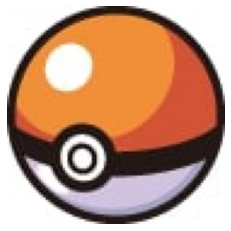

In [ ]:
files = load_file_names()
img = plt.imread(files[7])
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
N_epochs = 20
learning_rate = 0.001
batch_size = 15
N_training_examples = len(files)

N_parallel_iterations = 4
N_prefetch = 8
N_shuffle_buffer = 200

In [ ]:
""" Since we only have the file name and labels of the images, we need to actually load an image into system memory if it is needed. For this we will define a function that parses the image, normalizes it and reshapes
the label. This reshaping is a technical detail that avoids unintended behaivior during the calculation of the loss, i.e. it avoids unintended broadcasting. Your task is to fill in the missing code for loading,
decoding and normalizing the image. In this example we normalize the image to pixels in the range between 0 and 1. Hint: For reading and decoding the image use the functions defined in tf.io."""

def parse_func(filename):
    image_string = tf.io.read_file(filename)# Read the image
    image_decoded = tf.io.decode_jpeg(image_string, channels = 3)# Decode the image
    image_decoded = tf.image.resize(image_decoded, [200,200])
    image = (image_decoded - 127.5 )/ 127.5 # Normalize the image
    return image

""" We now build a tensorflow Dataset object that shuffles the data with a shuffle buffer of size "N_shuffle_buffer", applies the parse_func via the .map() function with "N_parallel_iterations", creates batches
of size "batch_size" and prefetches with "N_prefetch". Please fill in the missing code. """

def build_dataset(files, batch_size):
    # Create tf data set
    ds = tf.data.Dataset.from_tensor_slices((files)) # Create data set of files and labels
    ds = ds.shuffle(N_shuffle_buffer) # Enable shuffling
    ds = ds.map(parse_func,21) # Apply parse_func
    ds = ds.batch(batch_size, True) # Batch and prefetch
    ds = ds.prefetch(N_prefetch)
    return ds

""" Before partitioning the data and creating the tensorflow Dataset objects for training, validation and test, we need to shuffle. Please implement a shuffling of the data and the labels. """
# Shuffle data and labels
train_ds = build_dataset(files[0:N_training_examples], batch_size)


(15, 200, 200, 3)


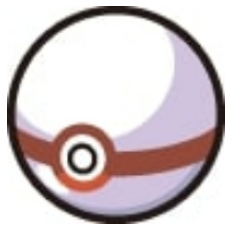

In [ ]:
for image_batch in train_ds:
  plt.imshow((np.squeeze(image_batch[0])+1)/2)
  #print(np.squeeze(image_batch[0]))
  print(np.shape(image_batch))
  plt.axis("off")
  plt.show()

# make_generator_model

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    # Fully connected layer:
    model.add(layers.Dense(25*25*128, use_bias=False, input_shape=(100,)))
    # Batch normm
    model.add(layers.BatchNormalization())
    # Activation function
    model.add(layers.LeakyReLU())
    # Reshape
    model.add(layers.Reshape((25, 25, 128)))
    # Layer 2: Hint use layers.Conv2DTranspose with 5x5 kernels and appropriate stride
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 25, 25, 64) # Note: None is the batch size
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # Layer 3
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 50, 50, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # Layer 4
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 100, 100, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # Layer 5
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 100, 100, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # Layer 6
    model.add(layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 200, 200, 8)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #Layer7
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 200, 200, 3)


    return model

In [ ]:
generator = make_generator_model()

# make_discriminator_model

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    # Layer 1: use layers.Conv2D with 5x5 kernels and appropriate stride
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[200, 200, 3]))
    # Activation function
    model.add(layers.LeakyReLU())
    # Dropout
    model.add(layers.Dropout(0.25))
    # Layer 2
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.25))
    # Layer 2
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.25))
    # Fully connected layer
    model.add(layers.Flatten())
    #model.add(layers.Dense(256))
    #model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1))
    return model

In [ ]:
discriminator = make_discriminator_model()


# loss function

In [ ]:
# This method returns a helper function to compute the binary cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    generator_loss = cross_entropy(tf.ones_like(fake_output),fake_output)
    return generator_loss

In [ ]:
learning_rate = 1e-4
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# restore check point

In [ ]:
!cp -r "/content/gdrive/My Drive/pokeball_cp_colored/" "pokeball_checkpoint"  #move file from A to B

In [ ]:
checkpoint_dir = './pokeball_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

status = checkpoint.restore(tf.train.latest_checkpoint('./pokeball_checkpoint'))

(1, 200, 200, 3)


(-0.5, 199.5, 199.5, -0.5)

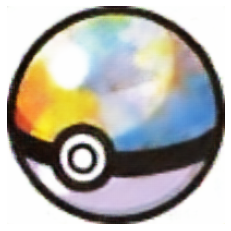

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)

plt.imshow((np.squeeze(generated_image) + 1) /2 )
plt.axis('off')

(1, 200, 200, 3)


(-0.5, 199.5, 199.5, -0.5)

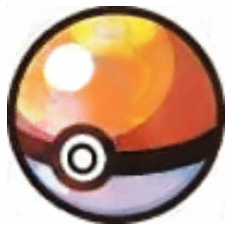

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)

plt.imshow((np.squeeze(generated_image) + 1) /2 )
plt.axis('off')

# training step

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16 # For visualization

# We will reuse this noise_vector overtime (so it's easier)
# to visualize progress in the animated GIF)
noise_vector = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise_vector = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # Generator output
      generated_images = generator(noise_vector, training=True)

      # Discriminator output
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      # Loss functions
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # Gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Update both networks
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
      # Produce images for the GIF as we go
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                             epoch + 1,
                             noise_vector)

    # Save the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
      #checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           noise_vector)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((np.squeeze((predictions[i]+1)/2)))
      #plt.imshow(np.array((predictions[i] + 1)/2), cmap='gray')
      #plt.imshow((predictions[i, :, :, 0] + 1)/2)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

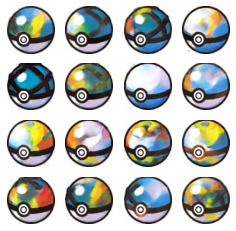

In [ ]:
#%%time
train(train_ds, 1000)

# save checkpoints

In [ ]:
checkpoint_dir = './pokeball_cp_colored_3'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

checkpoint.save(file_prefix = checkpoint_prefix)

'./pokeball_cp_colored_3/ckpt-1'

In [ ]:
!cp -r "pokeball_cp_colored_3" "/content/gdrive/My Drive/pokeball_cp_colored_3/" #move file from A to B